# What Defines Areas with High and Low Quality Bridges?

## Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Read in data and extract relevant data

In [2]:
with open("../data/cleaned.csv", "r") as f:
    df = pd.read_csv(f)
df.head()

,County,GEOID,State,Latitude,Longitude,Location,Year,StateAbbv,Bridges_Bridge area (square meters),"Bridges_Bridge area, fair (square meters)",...,Person trips_Trips 1-3 miles,Person trips_Trips 10-25 miles,Person trips_Trips 100-250 miles,Person trips_Trips 25-50 miles,Person trips_Trips 250-500 miles,Person trips_Trips 3-5 miles,Person trips_Trips 5-10 miles,Person trips_Trips 50-100 miles,Person trips_Trips greater than or equal to 500 miles,Person trips_Trips less than 1 mile
0,Abbeville County,45001,South Carolina,34.222593,-82.459165,POINT (-82.459165 34.222593),2014,SC,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Abbeville County,45001,South Carolina,34.222593,-82.459165,POINT (-82.459165 34.222593),2015,SC,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Abbeville County,45001,South Carolina,34.222593,-82.459165,POINT (-82.459165 34.222593),2016,SC,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abbeville County,45001,South Carolina,34.222593,-82.459165,POINT (-82.459165 34.222593),2017,SC,64177.63,22864.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Abbeville County,45001,South Carolina,34.222593,-82.459165,POINT (-82.459165 34.222593),2018,SC,73924.01,34151.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Determine the percentage of bridges in each county that are poor, averaged over time

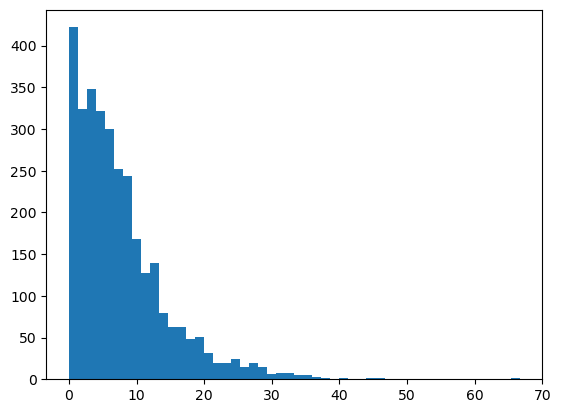

In [3]:
bridgeBin = df[["County","State","Year"] + [c for c in df.columns if "Bridges_" in c]].copy()
bridgeBin.dropna(subset=["Year"]+[c for c in bridgeBin.columns if "Bridges_" in c], inplace=True)
bridgeBin["Bridges_PctPoor"] = 100*bridgeBin["Bridges_Bridges, poor"] / bridgeBin["Bridges_Total bridges"]
bridgeBin = bridgeBin[["County","State","Bridges_PctPoor"]]
bridgeBin = bridgeBin.groupby(["County","State"], as_index = False).mean().reset_index(drop = True)
plt.hist(bridgeBin["Bridges_PctPoor"], bins = 50)
plt.show()

## Bin the percent-poor bridge data

In [4]:
bins = [0, 10, 20, 100]
labels = ['Good', 'Fair', 'Poor']
bridgeBin["BridgeQuality"] = pd.cut(bridgeBin["Bridges_PctPoor"], bins=bins, labels=labels, right=False)

## Clean up indicator data for analysis, aggregating across years as well

In [5]:
dfInd = df.drop(columns = ["GEOID","Latitude","Longitude"]+[c for c in df.columns if "Bridges_" in c])
dfInd = dfInd[["County","State","Location"] + 
            [c for c in dfInd.columns if "Business_" in c or
             "Person trips_" in c or
             c in ['Commuting_Commute by car/ truck/van',
                   'Commuting_Commute by public transportation',
                   "Demographics_Median Household Income",
                   "Demographics_Population"]]]

dfInd = dfInd.groupby(["County","State","Location"], as_index = False).mean().reset_index(drop = True)

dfInd["TotalCommute"] = dfInd["Commuting_Commute by car/ truck/van"] + dfInd["Commuting_Commute by public transportation"]
dfInd["TotalTrips_sub100"] = dfInd[[c for c in dfInd.columns if "Person trips_" in c and
                                    any(lab in c for lab in ["1-3","10-25",'25-50',"3-5","5-10","50-100","1 mile"])]].sum(axis = 1)
dfInd["TotalTrips_over100"] = dfInd["Person trips_Total trips"] - dfInd["TotalTrips_sub100"]
dfInd.drop(columns = [c for c in dfInd.columns if c != "Person trips_Total trips" and "Person trips_" in c], inplace = True)

dfInd["Commute_pctPersonal"] = 100*dfInd["Commuting_Commute by car/ truck/van"]/dfInd["TotalCommute"]
dfInd["Commute_pctPublic"] = 100 - dfInd["Commute_pctPersonal"]
dfInd.drop(columns = ["Commuting_Commute by car/ truck/van","Commuting_Commute by public transportation","TotalCommute"], inplace = True)

dfInd["Trips_pctOver100"] = 100*dfInd["TotalTrips_over100"]/dfInd["Person trips_Total trips"]
dfInd["Trips_pctSub100"] = 100 - dfInd["Trips_pctOver100"]
dfInd["Trips_perCap"] = dfInd["Person trips_Total trips"] / dfInd["Demographics_Population"]
dfInd.drop(columns = ["Person trips_Total trips","TotalTrips_sub100","TotalTrips_over100"], inplace = True)

dfInd["Business_EmpPer100"] = 100 * dfInd["Business_Employees"] / dfInd["Demographics_Population"]
dfInd["Business_EstabPerCap"] = dfInd["Business_Establishments"] / dfInd["Demographics_Population"]
dfInd.drop(columns = ["Business_Employees","Business_Establishments"], inplace = True)

dfInd.rename(columns = {
      "Demographics_Median Household Income":"medianIncome",
      "Demographics_Population":"population"
}, inplace = True)

dfInd.head()

,County,State,Location,medianIncome,population,Commute_pctPersonal,Commute_pctPublic,Trips_pctOver100,Trips_pctSub100,Trips_perCap,Business_EmpPer100,Business_EstabPerCap
0,Abbeville County,South Carolina,POINT (-82.459165 34.222593),35923.333333,24804.0,99.561047,0.438953,0.647084,99.352916,1282.925496,17.972908,0.013490
1,Acadia County,Louisiana,POINT (-92.411984 30.290536),40039.166667,62433.4,99.838331,0.161669,1.124911,98.875089,1349.207395,20.221868,0.017891
2,Accomack County,Virginia,POINT (-75.630317 37.763428),41474.500000,32886.0,99.247500,0.752500,0.558691,99.441309,1585.370081,26.077358,0.022399
3,Ada County,Idaho,POINT (-116.241161 43.451092),59973.500000,436263.4,99.497736,0.502264,0.931199,99.068801,1293.563586,44.416515,0.030492
4,Adair County,Iowa,POINT (-94.470966 41.33074),49542.333333,7231.4,99.582361,0.417639,1.945013,98.054987,1299.273446,25.259286,0.026717


## Merge the binned bridge qualities

In [6]:
df = pd.merge(left = bridgeBin.drop(columns = "Bridges_PctPoor"), right = dfInd.drop(columns = "Location"), on = ["County","State"], how = "inner")
df.head()

,County,State,BridgeQuality,medianIncome,population,Commute_pctPersonal,Commute_pctPublic,Trips_pctOver100,Trips_pctSub100,Trips_perCap,Business_EmpPer100,Business_EstabPerCap
0,Abbeville County,South Carolina,Good,35923.333333,24804.0,99.561047,0.438953,0.647084,99.352916,1282.925496,17.972908,0.013490
1,Acadia County,Louisiana,Good,40039.166667,62433.4,99.838331,0.161669,1.124911,98.875089,1349.207395,20.221868,0.017891
2,Accomack County,Virginia,Fair,41474.500000,32886.0,99.247500,0.752500,0.558691,99.441309,1585.370081,26.077358,0.022399
3,Ada County,Idaho,Good,59973.500000,436263.4,99.497736,0.502264,0.931199,99.068801,1293.563586,44.416515,0.030492
4,Adair County,Iowa,Fair,49542.333333,7231.4,99.582361,0.417639,1.945013,98.054987,1299.273446,25.259286,0.026717


## Median Income and Commute Numbers

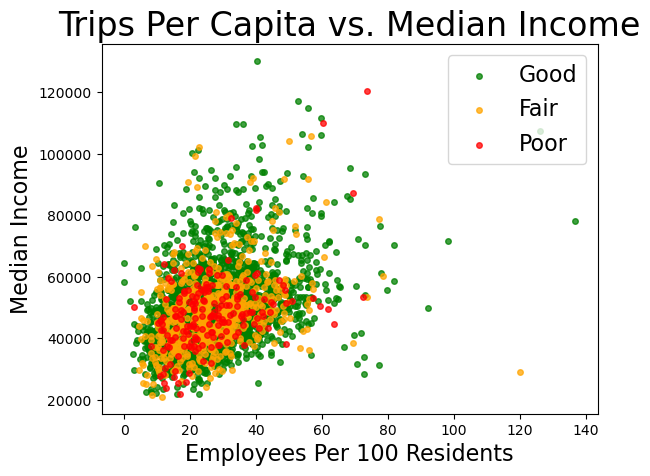

In [7]:
colors = {
    "Good":"green",
    "Fair":"orange",
    "Poor":"red"
}

for cat, color in colors.items():
    plotDf = df[df["BridgeQuality"] == cat]
    plt.scatter(plotDf["Business_EmpPer100"], plotDf["medianIncome"],
                color = color, label = cat, s = 16, alpha = 0.75)

plt.title("Trips Per Capita vs. Median Income", fontsize = 24)
plt.xlabel("Employees Per 100 Residents", fontsize = 16)
plt.ylabel("Median Income", fontsize = 16)

plt.legend(fontsize = 16)

plt.show()

## Income Versus Bridge Quality

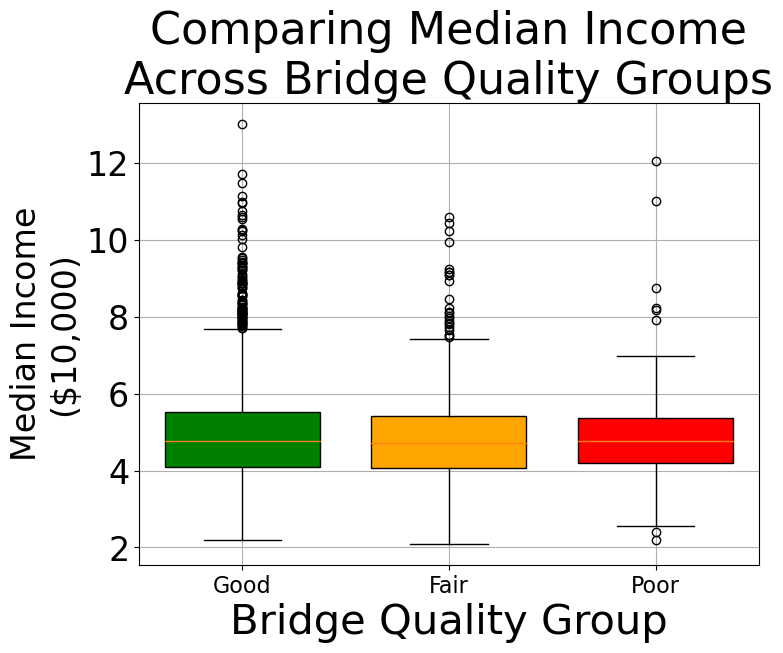

In [8]:
plt.figure(figsize=(8, 6))

boxplot = plt.boxplot([df[df['BridgeQuality'] == cat]['medianIncome']/10000 for cat in df['BridgeQuality'].unique()],
                      labels=df['BridgeQuality'].unique(),
                      patch_artist=True,
                      widths=0.75)

for box, cat in zip(boxplot['boxes'], df['BridgeQuality'].unique()):
    box.set(facecolor=colors[cat])

plt.title("Comparing Median Income\nAcross Bridge Quality Groups", fontsize = 32)
plt.xlabel('Bridge Quality Group', fontsize = 30)
plt.ylabel('Median Income\n($10,000)', fontsize = 24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=24)

plt.grid(True)
plt.show()


C:\Users\23898\AppData\Local\Temp\ipykernel_16852\2788544067.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  businessDf = businessDf.groupby(["BridgeQuality","BusinessPer1000"], as_index = False).sum()


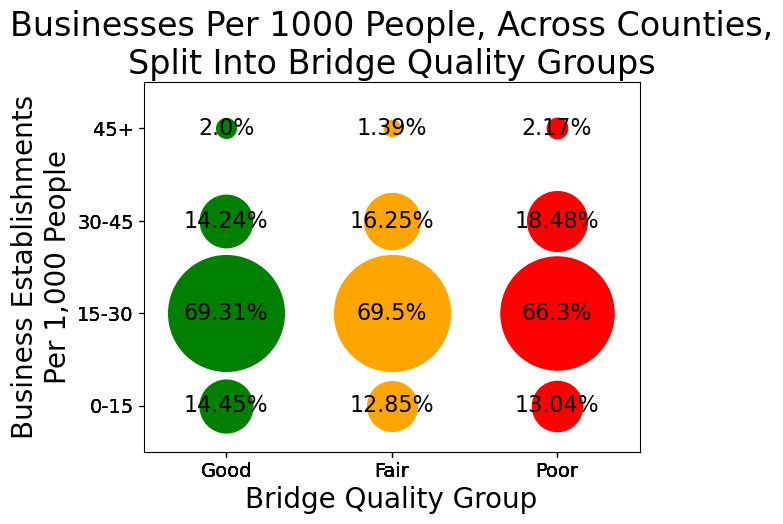

In [9]:
businessDf = df[["BridgeQuality","Business_EstabPerCap"]].copy()

businessDf["Business_EstabPerCap"] = 1000 * businessDf["Business_EstabPerCap"]
businessDf.rename(columns = {"Business_EstabPerCap":"BusinessPer1000"}, inplace = True)

bins = [0,15,30,45,businessDf["BusinessPer1000"].max()]
businessLabs = ['0-15', '15-30', '30-45', "45+"]
businessDf["BusinessPer1000"] = pd.cut(businessDf["BusinessPer1000"], bins=bins, labels=businessLabs, right=False)

businessDf['Size'] = 1
businessDf = businessDf.groupby(["BridgeQuality","BusinessPer1000"], as_index = False).sum()

for x, q_lab in enumerate(labels):
    total = businessDf[businessDf["BridgeQuality"] == q_lab]["Size"].sum()
    for y, b_lab in enumerate(businessLabs):
        size = businessDf[(businessDf["BridgeQuality"] == q_lab) & (businessDf["BusinessPer1000"] == b_lab)]["Size"].iloc[0]
        plt.scatter(x, y, s = 10000*size/total, color = colors[q_lab])
        plt.annotate(f"{round(100*size/total, 2)}%", (x, y), fontsize=16, ha='center', va='center')


plt.xlim((-0.5,2.5))
plt.xticks(businessDf["BridgeQuality"].map({k:i for i,k in enumerate(labels)}),businessDf["BridgeQuality"], fontsize = 14)

plt.ylim((-0.5,3.5))
plt.yticks(businessDf["BusinessPer1000"].map({k:i for i,k in enumerate(businessLabs)}),businessDf["BusinessPer1000"], fontsize = 14)

plt.xlabel("Bridge Quality Group", fontsize = 20)
plt.ylabel("Business Establishments\nPer 1,000 People", fontsize = 20)
plt.title("Businesses Per 1000 People, Across Counties,\nSplit Into Bridge Quality Groups", fontsize = 24)

plt.show()

c:\Users\23898\anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


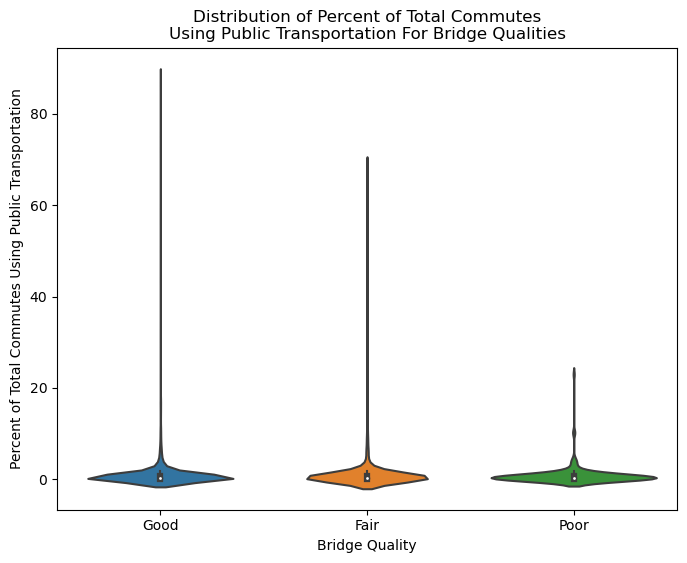

In [10]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='BridgeQuality', y='Commute_pctPublic', data=df)
plt.title('Distribution of Percent of Total Commutes\nUsing Public Transportation For Bridge Qualities')
plt.xlabel('Bridge Quality')
plt.ylabel('Percent of Total Commutes Using Public Transportation')
plt.show()

c:\Users\23898\anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


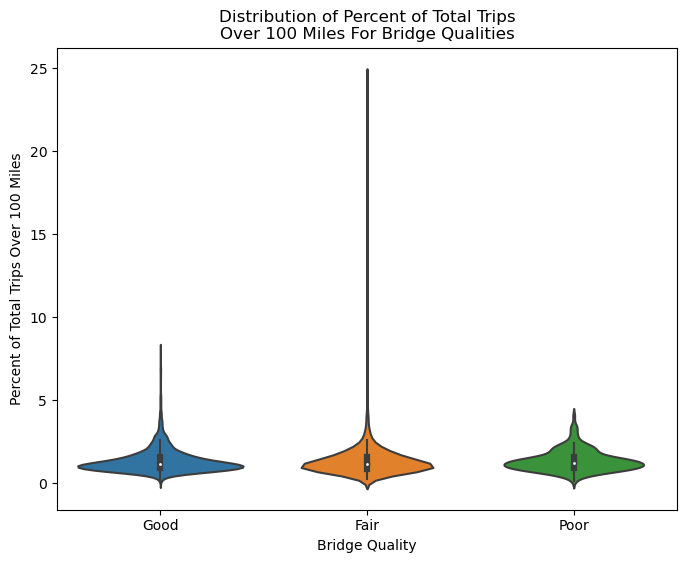

In [11]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='BridgeQuality', y='Trips_pctOver100', data=df)
plt.title('Distribution of Percent of Total Trips\nOver 100 Miles For Bridge Qualities')
plt.xlabel('Bridge Quality')
plt.ylabel('Percent of Total Trips Over 100 Miles')
plt.show()